# Домашнее задание - линейная регрессия

### Работа с признаками (8 баллов)

Скачайте датасет из материалов к уроку или по ссылке https://raw.githubusercontent.com/jupiterzhuo/travel-insurance/master/travel%20insurance.csv 


Описание признаков:

* Agency — название страхового агентства
* Agency Type — тип страхового агентства
* Distribution Channel — канал продвижения страхового агентства
* Product Name — название страхового продукта
* Duration — длительность поездки (количество дней)
* Destination — направление поездки
* Net Sales — сумма продаж 
* Commission (in value) — комиссия страхового агентства
* Gender — пол застрахованного
* Age — возраст застрахованного

Ответ:
* Claim — потребовалась ли страховая выплата: «да» — 1, «нет» — 0

Обработайте пропущенные значения и примените написанные функции onehot_encode() и minmax_scale().

**Подсказка**: маску для категориальных признаков можно сделать фильтром cat_features_mask = (df.dtypes == "object").values

Подробный анализ и подготовка датасета часто помогают улучшить качество модели. Ниже представлено несколько идей преобразований. Вы можете применить одно или несколько из этих преобразований (а можете не применять), чтобы помочь будущей модели.
- Посмотрите на количественные признаки. Возможно, в некоторых признаках есть выбросы - значения, которые сильно выбиваются. Такие значения полезно удалять. Советуем присмотреться к колонке Duration)
- Можно заметить, что one hot encoding сильно раздувает количество столбцов. Радикальное решение - можно попробовать выбросить все категориальные признаки из датасета.
- Если все-таки оставляете категориальные признаки, то подумайте, как уменьшить количество столбцов после one hot encoding. Признаки с большим количеством значений (Duration - 149! разных стран) можно удалить или попробовать сгруппировать некоторые значения.
- Downsampling. Датасет достаточно большой, разница в классах огромная. Можно уменьшить число наблюдений с частым ответом.

In [188]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import pandas as pd
import numpy as np

data = pd.read_csv("travel_insurance.csv")
data.columns = data.columns.str.lower().str.replace(' ', '_')

In [189]:
def onehot_encoding(x):
    objects = len(x)
    categories, indices = np.unique(x, return_inverse=True)
    num_values = len(categories)

    encoding_matrix = np.zeros((objects, num_values), dtype=int)

    for i, index in enumerate(indices):
        encoding_matrix[i, index] = 1

    return encoding_matrix

In [190]:
def minmax_scale(X):
    min_vals = X.min(axis=0)
    max_vals = X.max(axis=0)

    range_vals = np.where(min_vals == max_vals, 1, max_vals - min_vals)
    scaled_X = (X - min_vals) / range_vals

    return scaled_X

Выводим информацию о данных для понимания

In [191]:
print("Немного датасета")
data.head(10)

Немного датасета


,agency,agency_type,distribution_channel,product_name,claim,duration,destination,net_sales,commision_(in_value),gender,age
0,CBH,Travel Agency,Offline,Comprehensive Plan,No,186,MALAYSIA,-29.0,9.57,F,81
1,CBH,Travel Agency,Offline,Comprehensive Plan,No,186,MALAYSIA,-29.0,9.57,F,71
2,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,65,AUSTRALIA,-49.5,29.70,NaN,32
3,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,60,AUSTRALIA,-39.6,23.76,NaN,32
4,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,79,ITALY,-19.8,11.88,NaN,41
5,JZI,Airlines,Online,Value Plan,No,66,UNITED STATES,-121.0,42.35,F,44
6,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,47,UNITED STATES,-39.6,23.76,NaN,32
7,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,63,AUSTRALIA,-108.9,65.34,NaN,29
8,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,57,THAILAND,-19.8,11.88,NaN,44
9,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,186,AUSTRALIA,-99.0,59.40,NaN,37


In [192]:
print("Метрики факторов")
data.describe()

Метрики факторов


,duration,net_sales,commision_(in_value),age
count,63326.000000,63326.000000,63326.000000,63326.000000
mean,49.317074,40.702018,9.809992,39.969981
std,101.791566,48.845637,19.804388,14.017010
min,-2.000000,-389.000000,0.000000,0.000000
25%,9.000000,18.000000,0.000000,35.000000
50%,22.000000,26.530000,0.000000,36.000000
75%,53.000000,48.000000,11.550000,43.000000
max,4881.000000,810.000000,283.500000,118.000000


In [193]:
print("Данные о факторах")
data.info()

Данные о факторах
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63326 entries, 0 to 63325
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   agency                63326 non-null  object 
 1   agency_type           63326 non-null  object 
 2   distribution_channel  63326 non-null  object 
 3   product_name          63326 non-null  object 
 4   claim                 63326 non-null  object 
 5   duration              63326 non-null  int64  
 6   destination           63326 non-null  object 
 7   net_sales             63326 non-null  float64
 8   commision_(in_value)  63326 non-null  float64
 9   gender                18219 non-null  object 
 10  age                   63326 non-null  int64  
dtypes: float64(2), int64(2), object(7)
memory usage: 5.3+ MB


In [194]:
print("Пропуски в данных")
data.isnull().sum()

Пропуски в данных


agency                      0
agency_type                 0
distribution_channel        0
product_name                0
claim                       0
duration                    0
destination                 0
net_sales                   0
commision_(in_value)        0
gender                  45107
age                         0
dtype: int64

Информации в датасете достаточно много, тянет уж на ГС, а статистика все-таки про малые и не очень выборки, но удалять пустые значения не спешим, изучим датасет получше.

In [195]:
len(data)  #63326

63326

In [196]:
# data = data.dropna()

len(data)  #18219

63326

Так как разница в количестве данных, при удалении пропусков и без, слишком большая, стоит получше разобраться с датасетом, рассмотрим его графически:

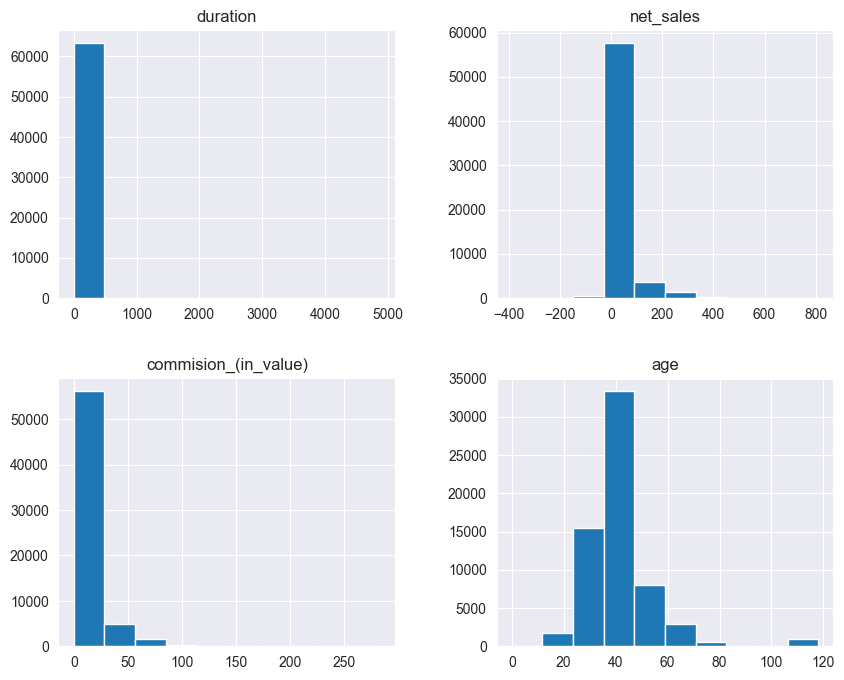

In [197]:
data.hist(figsize=(10, 8))
plt.show()

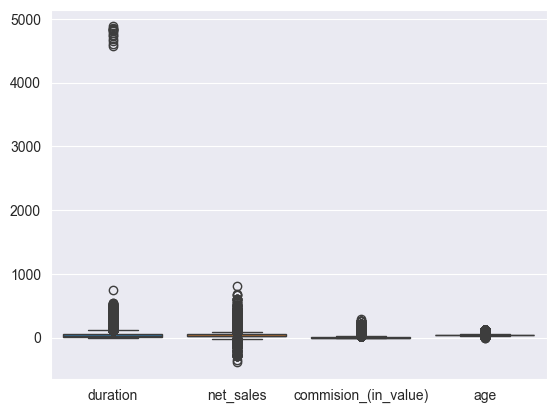

In [198]:
sns.boxplot(data=data)
plt.show()

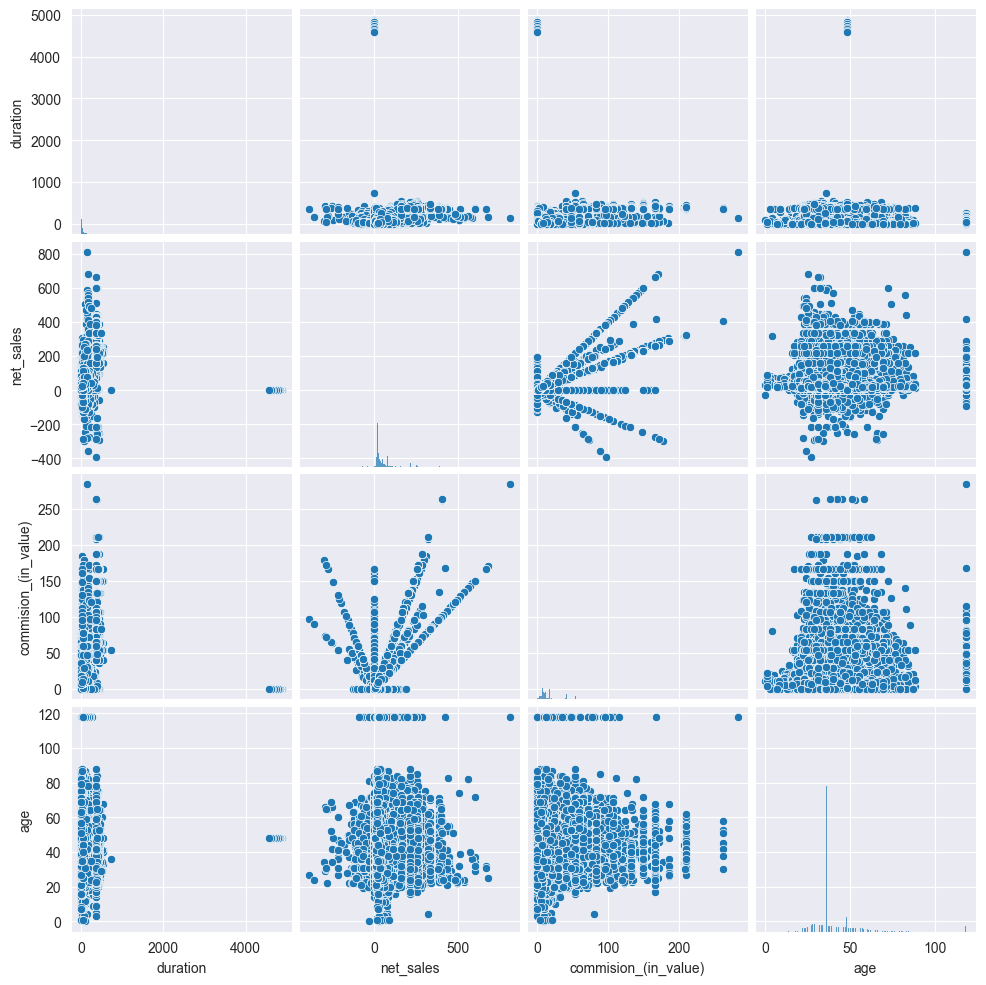

In [199]:
sns.pairplot(data)
plt.show()

63326 -> 18219 Разница оказалась чрезмерной, поэтому стоит скорее заменить медианой, где это можно, но это будет попозже.

Предусмотрим ситуацию с большим количеством факторов после применения onehotencoder, постараемся сгруппировать факторы.

In [200]:
print("Пункты назначения")
data["destination"].unique()

Пункты назначения


array(['MALAYSIA', 'AUSTRALIA', 'ITALY', 'UNITED STATES', 'THAILAND',
       "KOREA, DEMOCRATIC PEOPLE'S REPUBLIC OF", 'NORWAY', 'VIET NAM',
       'DENMARK', 'SINGAPORE', 'JAPAN', 'UNITED KINGDOM', 'INDONESIA',
       'INDIA', 'CHINA', 'FRANCE', 'TAIWAN, PROVINCE OF CHINA',
       'PHILIPPINES', 'MYANMAR', 'HONG KONG', 'KOREA, REPUBLIC OF',
       'UNITED ARAB EMIRATES', 'NAMIBIA', 'NEW ZEALAND', 'COSTA RICA',
       'BRUNEI DARUSSALAM', 'POLAND', 'SPAIN', 'CZECH REPUBLIC',
       'GERMANY', 'SRI LANKA', 'CAMBODIA', 'AUSTRIA', 'SOUTH AFRICA',
       'TANZANIA, UNITED REPUBLIC OF', "LAO PEOPLE'S DEMOCRATIC REPUBLIC",
       'NEPAL', 'NETHERLANDS', 'MACAO', 'CROATIA', 'FINLAND', 'CANADA',
       'TUNISIA', 'RUSSIAN FEDERATION', 'GREECE', 'BELGIUM', 'IRELAND',
       'SWITZERLAND', 'CHILE', 'ISRAEL', 'BANGLADESH', 'ICELAND',
       'PORTUGAL', 'ROMANIA', 'KENYA', 'GEORGIA', 'TURKEY', 'SWEDEN',
       'MALDIVES', 'ESTONIA', 'SAUDI ARABIA', 'PAKISTAN', 'QATAR', 'PERU',
       'LUXEMBOURG',

In [201]:
world_parts = {
    "MALAYSIA": "asia",
    "AUSTRALIA": "oceania",
    "ITALY": "europe",
    "UNITED STATES": "north_america",
    "THAILAND": "asia",
    "KOREA, DEMOCRATIC PEOPLE'S REPUBLIC OF": "asia",
    "NORWAY": "europe",
    "VIET NAM": "asia",
    "DENMARK": "europe",
    "SINGAPORE": "asia",
    "JAPAN": "asia",
    "UNITED KINGDOM": "europe",
    "INDONESIA": "asia",
    "INDIA": "asia",
    "CHINA": "asia",
    "FRANCE": "europe",
    "TAIWAN, PROVINCE OF CHINA": "asia",
    "PHILIPPINES": "asia",
    "MYANMAR": "asia",
    "HONG KONG": "asia",
    "KOREA, REPUBLIC OF": "asia",
    "UNITED ARAB EMIRATES": "asia",
    "NAMIBIA": "africa",
    "NEW ZEALAND": "oceania",
    "COSTA RICA": "north_america",
    "BRUNEI DARUSSALAM": "asia",
    "POLAND": "europe",
    "SPAIN": "europe",
    "CZECH REPUBLIC": "europe",
    "GERMANY": "europe",
    "SRI LANKA": "asia",
    "CAMBODIA": "asia",
    "AUSTRIA": "europe",
    "SOUTH AFRICA": "africa",
    "TANZANIA, UNITED REPUBLIC OF": "africa",
    "LAO PEOPLE'S DEMOCRATIC REPUBLIC": "asia",
    "NEPAL": "asia",
    "NETHERLANDS": "europe",
    "MACAO": "asia",
    "CROATIA": "europe",
    "FINLAND": "europe",
    "CANADA": "north_america",
    "TUNISIA": "africa",
    "RUSSIAN FEDERATION": "europe",
    "GREECE": "europe",
    "BELGIUM": "europe",
    "IRELAND": "europe",
    "SWITZERLAND": "europe",
    "CHILE": "south_america",
    "ISRAEL": "asia",
    "BANGLADESH": "asia",
    "ICELAND": "europe",
    "PORTUGAL": "europe",
    "ROMANIA": "europe",
    "KENYA": "africa",
    "GEORGIA": "asia",
    "TURKEY": "asia",
    "SWEDEN": "europe",
    "MALDIVES": "asia",
    "ESTONIA": "europe",
    "SAUDI ARABIA": "asia",
    "PAKISTAN": "asia",
    "QATAR": "asia",
    "PERU": "south_america",
    "LUXEMBOURG": "europe",
    "MONGOLIA": "asia",
    "ARGENTINA": "south_america",
    "CYPRUS": "asia",
    "FIJI": "oceania",
    "BARBADOS": "north_america",
    "TRINIDAD AND TOBAGO": "north_america",
    "ETHIOPIA": "africa",
    "PAPUA NEW GUINEA": "oceania",
    "SERBIA": "europe",
    "JORDAN": "asia",
    "ECUADOR": "south_america",
    "BENIN": "africa",
    "OMAN": "asia",
    "BAHRAIN": "asia",
    "UGANDA": "africa",
    "BRAZIL": "south_america",
    "MEXICO": "north_america",
    "HUNGARY": "europe",
    "AZERBAIJAN": "asia",
    "MOROCCO": "africa",
    "URUGUAY": "south_america",
    "MAURITIUS": "africa",
    "JAMAICA": "north_america",
    "KAZAKHSTAN": "asia",
    "GHANA": "africa",
    "UZBEKISTAN": "asia",
    "SLOVENIA": "europe",
    "KUWAIT": "asia",
    "GUAM": "oceania",
    "BULGARIA": "europe",
    "LITHUANIA": "europe",
    "NEW CALEDONIA": "oceania",
    "EGYPT": "africa",
    "ARMENIA": "asia",
    "BOLIVIA": "south_america",
    "VIRGIN ISLANDS, U.S.": "north_america",
    "PANAMA": "north_america",
    "SIERRA LEONE": "africa",
    "COLOMBIA": "south_america",
    "PUERTO RICO": "north_america",
    "UKRAINE": "europe",
    "GUINEA": "africa",
    "GUADELOUPE": "north_america",
    "MOLDOVA, REPUBLIC OF": "europe",
    "GUYANA": "south_america",
    "LATVIA": "europe",
    "ZIMBABWE": "africa",
    "VANUATU": "oceania",
    "VENEZUELA": "south_america",
    "BOTSWANA": "africa",
    "BERMUDA": "north_america",
    "MALI": "africa",
    "KYRGYZSTAN": "asia",
    "CAYMAN ISLANDS": "north_america",
    "MALTA": "europe",
    "LEBANON": "asia",
    "REUNION": "africa",
    "SEYCHELLES": "africa",
    "ZAMBIA": "africa",
    "SAMOA": "oceania",
    "NORTHERN MARIANA ISLANDS": "oceania",
    "NIGERIA": "africa",
    "DOMINICAN REPUBLIC": "north_america",
    "TAJIKISTAN": "asia",
    "ALBANIA": "europe",
    "MACEDONIA, THE FORMER YUGOSLAV REPUBLIC OF": "europe",
    "LIBYAN ARAB JAMAHIRIYA": "africa",
    "ANGOLA": "africa",
    "BELARUS": "europe",
    "TURKS AND CAICOS ISLANDS": "north_america",
    "FAROE ISLANDS": "europe",
    "TURKMENISTAN": "asia",
    "GUINEA-BISSAU": "africa",
    "CAMEROON": "africa",
    "BHUTAN": "asia",
    "RWANDA": "africa",
    "SOLOMON ISLANDS": "oceania",
    "IRAN, ISLAMIC REPUBLIC OF": "asia",
    "GUATEMALA": "north_america",
    "FRENCH POLYNESIA": "oceania",
    "TIBET": "asia",
    "SENEGAL": "africa",
    "REPUBLIC OF MONTENEGRO": "europe",
    "BOSNIA AND HERZEGOVINA": "europe"
}

In [202]:
print("Типы планов")
data["product_name"].unique()

Типы планов


array(['Comprehensive Plan', 'Rental Vehicle Excess Insurance',
       'Value Plan', 'Basic Plan', 'Premier Plan',
       '2 way Comprehensive Plan', 'Bronze Plan', 'Silver Plan',
       'Annual Silver Plan', 'Cancellation Plan',
       '1 way Comprehensive Plan', 'Ticket Protector', '24 Protect',
       'Gold Plan', 'Annual Gold Plan',
       'Single Trip Travel Protect Silver',
       'Individual Comprehensive Plan',
       'Spouse or Parents Comprehensive Plan',
       'Annual Travel Protect Silver',
       'Single Trip Travel Protect Platinum',
       'Annual Travel Protect Gold', 'Single Trip Travel Protect Gold',
       'Annual Travel Protect Platinum', 'Child Comprehensive Plan',
       'Travel Cruise Protect', 'Travel Cruise Protect Family'],
      dtype=object)

In [203]:
plan_mapping = {
    "Basic Plan": "basic",
    "Value Plan": "basic",
    "Cancellation Plan": "basic",
    "Comprehensive Plan": "basic",
    "2 way Comprehensive Plan": "basic",
    "1 way Comprehensive Plan": "basic",
    "Ticket Protector": "basic",
    "Single Trip Travel Protect Silver": "premium",
    "Single Trip Travel Protect Gold": "deluxe",
    "Single Trip Travel Protect Platinum": "deluxe",
    "Annual Silver Plan": "premium",
    "Annual Gold Plan": "deluxe",
    "Annual Travel Protect Silver": "premium",
    "Annual Travel Protect Gold": "deluxe",
    "Annual Travel Protect Platinum": "deluxe",
    "Rental Vehicle Excess Insurance": "premium",
    "Bronze Plan": "premium",
    "Silver Plan": "premium",
    "Gold Plan": "deluxe",
    "Premier Plan": "deluxe",
    "24 Protect": "deluxe",
    "Travel Cruise Protect": "basic",
    "Travel Cruise Protect Family": "premium",
    "Individual Comprehensive Plan": "basic",
    "Spouse or Parents Comprehensive Plan": "basic",
    "Child Comprehensive Plan": "basic"
}

Сгруппируем данные по региону поездки и типу плана

In [204]:
data["destination"] = data["destination"].map(world_parts)
data["product_name"] = data["product_name"].map(plan_mapping)

Фактор Agency серьезно раздувает датасет (после применения onehotencoder и сгруппировать его не особо можно), стоит его исключить из данных.

In [205]:
data = data.drop(columns=["agency"])

Заменим пустые значения в данных медианой, самым популярным ответом.

In [206]:
numeric_features = data.select_dtypes(include=['int', 'float']).columns

data['claim'] = np.where(data['claim'] == 'Yes', 1, 0)

categorical_features = data.select_dtypes(include=['object']).columns

# Заполнение числовых признаков медианой
numeric_imputer = SimpleImputer(strategy='median')
data[numeric_features] = numeric_imputer.fit_transform(data[numeric_features])

# Заполнение для категориальных признаков наиболее часто встречающимся значением
categorical_imputer = SimpleImputer(strategy='most_frequent')
data[categorical_features] = categorical_imputer.fit_transform(data[categorical_features])

print("Пропуски в данных")
print(data.isnull().sum())

Пропуски в данных
agency_type             0
distribution_channel    0
product_name            0
claim                   0
duration                0
destination             0
net_sales               0
commision_(in_value)    0
gender                  0
age                     0
dtype: int64


Пропусков не осталось, все хорошо

Исходя из вышеуказанных визуализаций, нетрудно понять, что в данных есть выбросы, стоит их удалить.

In [207]:
z_scores = stats.zscore(data.select_dtypes(include=['int64', 'float64']))

outlier_mask = (abs(z_scores) > 3).any(axis=1)

data = data[~outlier_mask]

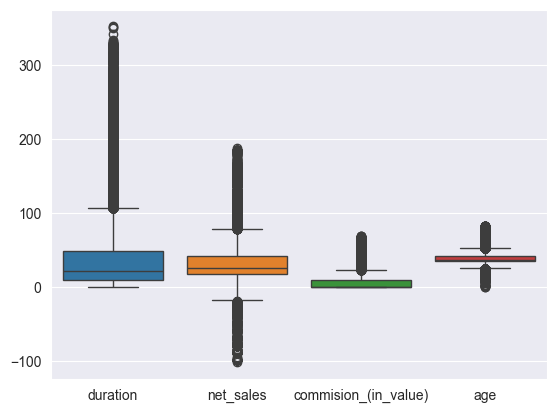

Длина датасета: 59585


In [208]:
sns.boxplot(data=data[data.select_dtypes(include=['int64', 'float64']).columns])
plt.show()
print(f"Длина датасета: {len(data)}")

Ситуация уже получше

In [209]:
data.isnull().sum()

agency_type             0
distribution_channel    0
product_name            0
claim                   0
duration                0
destination             0
net_sales               0
commision_(in_value)    0
gender                  0
age                     0
dtype: int64

In [210]:
encoded_columns = []
for col in categorical_features:
    encoded_data = onehot_encoding(data[col])
    categories = np.unique(data[col])
    encoded_df = pd.DataFrame(encoded_data, columns=[f"{col}_{cat.lower().replace(' ', '_')}" for cat in categories])
    encoded_columns.append(encoded_df)


data_encoded = pd.concat(encoded_columns, axis=1)
data = data.drop(columns=categorical_features)
data = pd.concat([data, data_encoded], axis=1)
data = minmax_scale(data)

In [211]:
data = data.dropna()

In [212]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56244 entries, 0 to 59584
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   claim                         56244 non-null  float64
 1   duration                      56244 non-null  float64
 2   net_sales                     56244 non-null  float64
 3   commision_(in_value)          56244 non-null  float64
 4   age                           56244 non-null  float64
 5   agency_type_airlines          56244 non-null  float64
 6   agency_type_travel_agency     56244 non-null  float64
 7   distribution_channel_offline  56244 non-null  float64
 8   distribution_channel_online   56244 non-null  float64
 9   product_name_basic            56244 non-null  float64
 10  product_name_deluxe           56244 non-null  float64
 11  product_name_premium          56244 non-null  float64
 12  destination_africa            56244 non-null  float64
 13  destin

In [213]:
data.describe()

,claim,duration,net_sales,commision_(in_value),age,agency_type_airlines,agency_type_travel_agency,distribution_channel_offline,distribution_channel_online,product_name_basic,product_name_deluxe,product_name_premium,destination_africa,destination_asia,destination_europe,destination_north_america,destination_oceania,destination_south_america,gender_f,gender_m
count,56244.000000,56244.000000,56244.000000,56244.000000,56244.000000,56244.000000,56244.000000,56244.000000,56244.000000,56244.000000,56244.000000,56244.000000,56244.000000,56244.000000,56244.000000,56244.000000,56244.000000,56244.000000,56244.000000,56244.000000
mean,0.011575,0.107242,0.468001,0.097019,0.470713,0.246160,0.753840,0.015184,0.984816,0.744222,0.016944,0.238834,0.004836,0.795267,0.080133,0.048218,0.068149,0.003396,0.124138,0.875862
std,0.106962,0.128994,0.094675,0.172787,0.119269,0.430776,0.430776,0.122285,0.122285,0.436302,0.129063,0.426375,0.069374,0.403510,0.271501,0.214229,0.252004,0.058176,0.329741,0.329741
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.025568,0.415225,0.000000,0.426829,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.059659,0.442561,0.000000,0.439024,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,0.136364,0.498270,0.131579,0.512195,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Для оптимизации, сделаем downsampling, проверим результаты.

data = data.sample(frac=0.5, random_state=42)

data.reset_index(drop=True, inplace=True)

print(len(data))
data.describe()

При frac=0.5, разница в данных есть, но не существенна, но все же выбран 0.75 для наилучшего баланса сохранения исходных данных, оптимизации.

### Применение линейной регрессии (10 баллов)

Это задача классификации, но её можно решить с помощью линейной регрессии, если округлять предсказанный ответ до целого и выбирать ближайший по значению ответ из множества {0, 1}.

Вынесите признак 'Claim' в вектор ответов и разделите датасет на обучающую и тестовую выборку в соотношении 80 к 20. Зафиксируйте random_state.

**Подсказка:** быстро перевести Yes/No в 1/0 можно так - np.where(df['Claim'] == 'Yes', 1,0)

In [214]:
y = data['claim']

print(y.value_counts()) # проверяем наличие значений целевых переменных (иначе модель бесполезна)

X = data.drop(columns=['claim'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

claim
0.0    55593
1.0      651
Name: count, dtype: int64


Постройте модель LinearRegression, примените к тестовой выборке и посчитайте MSE (можно использовать библиотеку sklearn)

In [215]:
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_rounded = np.round(y_pred)

unique_values, counts = np.unique(y_pred_rounded, return_counts=True)
value_counts = dict(zip(unique_values, counts))
print(value_counts)

{0.0: 11249}


In [216]:
mse = mean_squared_error(y_test, y_pred_rounded)
print("MSE:", mse)

MSE: 0.011734376389012357


Найдите аналитическое решение для обучающей выборки: обычное и регуляризацией l2. 

In [217]:
# посчитайте аналитическое решение
X_train = np.array(X_train)
y_train = np.array(y_train)
normal_pred = np.linalg.inv(X_train.T.dot(X_train)).dot(X_train.T).dot(y_train)
normal_pred = np.round(normal_pred)

print("Обычная линейная регрессия:", normal_pred)

Обычная линейная регрессия: [ 1.00000000e+00 -1.00000000e+00  0.00000000e+00 -2.00000000e+00
  4.94138895e+13  4.94138895e+13  1.00278609e+13  1.00278609e+13
 -1.61353868e+13 -1.61353868e+13 -1.61353868e+13 -4.33063636e+13
 -4.33063636e+13 -4.33063636e+13 -4.33063636e+13 -4.33063636e+13
 -4.33063636e+13 -1.00000000e+00 -1.00000000e+00]


In [218]:
# посчитать аналитическое решение с регуляризацией
lambda_value = 0.1
I = np.eye(X_train.shape[1])
l2_pred = np.linalg.inv(X_train.T.dot(X_train) + lambda_value * I).dot(X_train.T).dot(y_train)
l2_pred = np.round(l2_pred)

print("Регрессия с регуляризацией L2:", l2_pred)

Регрессия с регуляризацией L2: [-0.  0.  0. -0.  0. -0.  0. -0. -0.  0.  0.  0.  0.  0.  0. -0. -0. -0.
  0.]


### Вывод (1 балла)

Напишите краткий вывод по заданию (достаточно пары предложений). Расскажите, какие способы предобработки данных вы выбрали и почему. Насколько хороша ваша модель?

В целом решение данной задачи через линейную регрессию больше похоже на костыль, но несмотря на это сама модель показывает неплохие результаты: MSE, при показателях целевой переменной от 0 до 1, вполне адекватная. Предобработка данных: заменить пустые значения медианой, самым популярным ответом; удалить выбросы; сгруппировать категориальные факторы destination и product name; удалить фактор agency; закинуть категориальные факторы в onehotencoder, юзануть minmaxscaler. Вполне возможно, что при построении модели были допущены какие-то ошибки и использовать данную модель для реальных бизнес-решений скорее не надо.